## Lab 9: Integration (Software)


Written by Kourosh Hakhamaneshi (Spring 2020)


-----

### Design and Simulation of LQR controller for DC motors

In this lab you will design an LQR (linear quadratic regulator) controller for a DC motor and simulate the system using LTSpice. You need to write your report on this notebook in Markdown. Use latex whenever you have to. For figures either use `<img>` tags or provide the code-snippet that will generate the figures in place. You will turn in both the `.pdf` and `.ipynb` versions of this notebook as your project report, and your checkoff for this lab will count as your "Final Demo". If the packages are not successfully installed using this notebook consider installing with command line using `pip` or `conda`.

-----

## Table of Contents

* [Introduction](#intro)
* [Open loop control](#olc)
* [Closed loop control](#clc)




In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install --no-binary slycot control

In [2]:
# import packages
import control
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


----

<a id='intro'></a>
## 1. Introduction: System Model

The DC motor is one of the most common actuators in control systems. It converts the electrical energy to rotational motion. The electrical equivalent circuit of the armatrure and the diagram of the rotor are shown below:

<img style="width:500px" src="images/model.png">

The input to the system is the voltage applied to the motor's armature, and the output is the rotational velocity $\omega_r = \dot{\theta}$. The rotor and shaft are assumed to be rigid and we will assume the viscous friction model is appropriate, meaning that the friction torque will be proportional to angular velocity. Thusly, friction can be modeled by a viscous damper, shown in the table below.

Let's review some physics. In general, the torque generated by a DC motor is positively correlated to the armature current. We assume this correlation is linear with a constant factor $K_T$:

$$T = K_T i$$

Moreover, as the motor rotates a voltage will be induced which opposes the input voltage source. It is generated by the rotation of the electrical coil through the flux lines of the permanent magnets (i.e., the magnetic field). This voltage is often referred to as the back EMF (Electromotive Force), and its value is proportional to the angular velocity:

$$V_{emf} = K_e \omega_r$$

Usually $K_e = K_T$; therefore, we will use $K_C$ to represent both the motor torque constant and the back EMF constant (the C stand for constant). 

For your convenience, the table below summarizes the models of commonly-used rotational mechanical components:

|Component  | Torque-angular velocity equation    | Torque-angular displacement equation |
|:---------:|:-----------------------------------:|:------------------------------------:|
|<img src="images/spring.png" alt="spring" width="100"/> | $T(t) = K_s \int^t_0 \omega(\tau)d\tau$ |$T(t) = K_s\theta(t)$                   | 
|<img src="images/damper.png" alt="damper" width="100"/>| $T(t) = b\omega(t)$             |$T(t) = b\frac{d\theta(t)}{dt}$       | 
|<img src="images/inertia.png" alt="inertia" width="100"/>    | $T(t) = J\frac{d\omega(t)}{dt}$     | $T(t) = J\frac{d^2\omega(t)}{dt^2}$  |

The generated torque due to the electrical input has to overcome some rotational friction $b$ and the inertia of the rotor $J$. From [Newton's second law](http://www.4physics.com/phy_demo/newton/newton_rot.htm) we can write the following differential equation: 

$$J\frac{\partial \omega_r(t)}{\partial t} + b \omega_r(t) = K_C i(t) \hspace{2cm} (1)$$ 

We can also write a KVL on the input side:

$$L_e\frac{\partial i(t)}{\partial t} + R_e i(t) = V_{in}(t) - K_C\omega_r(t) \hspace{0.6cm} (2)$$

The table below summarizes the meaning of each parameter in the model.

| Parameter | Meaning                                | ----- Units -----  |
|:---------:|:--------------------------------------:|:------------------------:|
| $J$       | Moment of inertia of the rotor         | $kg\cdot m^2$           |
| $b$       | Motor viscous friction constant        | $N\cdot m\cdot s$             |
| $K_C$       | In Newton's eq: Motor torque constant  | $N\cdot m/A$             |
| $K_C$       | In KVL: EMF constant                   | $\frac{V\cdot s}{rad}$   |
| $R_e$     | Electrical resistance                  | $\Omega$            |
| $L_e$     | Electrical inductance                  | $H$                 |





### Part 1

We have a system of linear differential equations (1 and 2 above) that can be expressed in the state-space form $\dot{x} = Ax + Bu$, and $y = Cx + Du$. 

-----

**1.1.1. Select the $i(t)$ and $w_r(t)$ as your state-variables and write down the state-space form in the space provided below (preferably in latex)**


### 1.1.1. Answer:
$\vec{x} =
\begin{bmatrix}
\omega_r \\ i
\end{bmatrix}$

$y = C\vec{x} + Du = \omega_r =
\begin{bmatrix}
1 & 0
\end{bmatrix}
\begin{bmatrix}
\omega_r \\ i
\end{bmatrix}
+ 0\cdot V_{in}$



$\frac{\partial}{\partial t}
\begin{bmatrix}
\omega_r \\ 
i
\end{bmatrix} = 
\begin{bmatrix}
-\frac{b}{J} & \frac{K_C}{J} \\
-\frac{K_C}{L_e} & -\frac{R_e}{L_e}
\end{bmatrix}
\begin{bmatrix}
\omega_r \\ 
i
\end{bmatrix} + 
\begin{bmatrix}
0 \\ 
\frac{1}{L_e}
\end{bmatrix}V_{in} =
A\vec{x} + Bu$

-----

**1.1.2. Find the controllability matrix for the system. Under what condition is the system controllable? What condition does this impose on one of the constant values? Which constant? Write a python method that checks the controllability.  ** (Hint: look up `np.linalg.matrix_rank()`.)

### 1.1.2. Answer: 


$C = \begin{bmatrix}B & AB\end{bmatrix} =
\begin{bmatrix}
0 & \frac{K_c}{L_eJ}\\
\frac{1}{L_e} & -\frac{R_e}{L_e^2}
\end{bmatrix}$
The system is controllable when $K_c \ne 0$

In [3]:
def is_controllable(A, B):
    C = B
    #print("A =\n", A)
    #print("B =\n", B)
    #print("C =\n", C)
    for i in range(A.shape[1] - 1):
        #print("i + 1 =", i + 1)
        AB = np.linalg.matrix_power(A, i + 1)@(B)
        #print("AB =\n", AB)
        C = np.hstack((C, AB))
        #print("C in progresss =\n", C)
    return np.linalg.matrix_rank(C) == C.shape[1]

In [4]:
# Test controllable
# not controllable
A = np.array([[1, 1, 0],
              [0, 1, 0],
              [0, 0, 1]])

B = np.array([[0, 1, 1]]).T

print(is_controllable(A, B))

# controllable
A = np.array([[1, 1],
              [0, 1]])

B = np.array([[0, 1]]).T

print(is_controllable(A, B))

False
True


-----

### Part 2

We now want to create an RL (resistor, inductor, and sources) circuit that reflects the dynamics of the DC motor. To do this we need to find the equivalent circuit of the mechanical part. 

-----

**1.2.1. Using only resistor(s), inductor(s) and dependent/independent voltage sources, design a system of two circuits that has the same system of differential equations as the DC motor system modeled by equations (1) and (2). Report which parameters in your system correspond to $J$, $b$, and $\omega_r(t)$. In other words, show how the purely electrical system emulates the DC motor system.**

Hint 1: Current-dependent voltage sources are your friends. Also, you can set them to depend on *any* current in the system.

Hint 2: To help you with deriving equivalences, it may be useful to note that another term for voltage is electromotive **force**. 

Hint 3: If you have not consulted it yet, the [Newton's second law](http://www.4physics.com/phy_demo/newton/newton_rot.htm) link contains a lot of information.


### 1.2.1. Answer:
<img src="work/1.2.1_circuit3.jpg" alt="1.2.1_circuit" width="1200"/> 

-----

**1.2.2. Draw your circuit in the `ol_model.asc` file in LTSpice. Set the initial condition for $\omega_r$ to 500 rad/sec (this is already done for you by the `.ic` directive at the bottom). Make your input a voltage step with 1 Volt amplitude, delay of 1 second, $T_{on}=10\mu$ seconds, $T_{fall}=10\mu$ seconds,  $T_{rise}=10$ seconds, and $T_{per}=100 $ seconds (this should be set for you already). Run a transient simulation for 20 seconds (this is what the `.tran 20` directive at the bottom does), and plot the input, state variables, and output on separate graphs. Assume the model has the following parameter values:**

$$R_e = 5.5, L_e = 50 \mu, b=300n, J=15n, K=900\mu$$

**Use KCL to compute the final values of the state variables by hand. In your answer, include the schematic capture (a screenshot of your SPICE schematic is fine), simulation waveforms, your calculation, and your explanation of the results. See if the DC behavior of the circuit from your hand calculations matches the simulation. Also comment on the waveform of $i(t)$ and $\omega_r(t)$.**

Hints: 

* (For hand calcualtion:) Think about what happens to inductors at steady-state. Can you simplify your circuits?

* For the current-controlled voltage sources, use the behavioural voltage source component `bv` in LTSpice. `I(Cx)` denotes current through component Cx. 

* Use `res` for resistors, and `ind` for inductors. 

* By default, inductors in LTSpice have $1 m\Omega$ series resistor, if not specified. Make sure you explicitly set it to zero.

* **Pay close attention to the direction of the current that you are using in your equations.**

* Label the nets (wires) where you want to measure voltage to make plotting easier. To do this, right-click on some empty space in your schematic and select Draft > Net Name.

* To plot the quantities on separate graphs, before you plot anything, right-click on the plot background and choose "Add Plot Pane." Add enough panes to plot each quantity on a separate graph. Then, right click on a pane and select "Add Traces" and plot the quantity you want.

* To format your plot, click on the hammer on the plot window. Change the line thickness to 1.5. Then, select Configure Colors and set the background to white and the axis to black. 


### 1.2.2. Answer:


In [5]:
Re = 5.5
Le = 50e-6
b = 300e-9
J = 15e-9
K = 900e-6
#A = np.array([[-b/J, K/J],
#             [-K/Le, -Re/Le]])
#B = np.array([[0],
#              [1/Le]])
#Ax = y
A = np.array([[b, -K],
            [K, Re]])
y = np.array([[0],
             [1]])
x_ss = np.linalg.inv(A)@y
print(x_ss)

[[3.65853659e+02]
 [1.21951220e-01]]


Hand calculation: At steady-state with zero input, the inductors behave like shorts and so the current dies down until both state variables reach zero

$b\omega_r - Ki = 0$

$K\omega_r + iR_e = V_{in}$

$\begin{bmatrix}
b & -K \\
K & R_e\end{bmatrix}
\begin{bmatrix}
\omega_r \\ i
\end{bmatrix} = 
\begin{bmatrix}
0 \\ V_{in} \end{bmatrix}$

And when $V_{in} = 1$, steady $\vec{x}_{ss} = \begin{bmatrix}
366 \\ 0.122 \end{bmatrix} = \begin{bmatrix}
\omega_{r_{ss}} \\ i_{ss} \end{bmatrix}$
<img src="work/1.2.2_plots.jpg" alt="1.2.2_plots" width="1200"/> 
<img src="work/1.2.2_circuit2.jpg" alt="1.2.2_circuit" width="1200"/> 

<a id='olc'></a>

-----

## 2. Open-loop control

Now that we have a working simulation environment in LTSpice we can test different scenarios. The first thing to check is to see if open-loop control works on the system. We will use `.ic` diectives in Spice to set initial condition on state variables that are not their final values. You can see the example usage of ic in `ol_model.asc`.

-----

**2.1. Find $V_{in}$ in terms of $\omega_r$ and constants. What value for $V_{in}$ yields $w_r = 100\ rad / s$? Set the initial condition on $w_r(0) = 500 \frac{rad}{seconds}$ (this should be already done for you by the `.ic` directive at the bottom), and leave the inital condition on armature current intact. Set the simulation time to 2.5 seconds. Report your steady state error. Also include your calculation and the waveforms in your answer.**

### 2.1. Answer:


$i = \frac{b\omega_r}{K}$

$K\omega_r + iR_e = V{in} = K\omega_r + \frac{b\omega_r}{K}R_e = \omega_r(K\ + \frac{b}{K}R_e)$

In [6]:
Vin = 100*(K + b/K*Re)
print(Vin)

0.2733333333333333


So we need a voltage of 0.0.2733333333333333 volts on $V_{in}$ to get a $\omega_r = 100\ rad / s$ There is 0 steady state error between the calculation and the simulation.
<img src="work/2.1_plots.jpg" alt="2.1_plots" width="1200"/> 
<img src="work/2.1_circuit.jpg" alt="2.1_circuit" width="1200"/> 

-----

**2.2. Now simulate using the following model parameters, and report the steady-state error using the input you found in 2.1.**

$$R_e = 10, L_e = 60 \mu, b=400n, J=20n, K=1m$$

**How is open-loop contol's performance once you have mismatch?**


### 2.2. Answer:

In [7]:
print(100 - 54.666666)
print((100 - 54.666666)/100)

45.333334
0.45333334000000003


$\omega_r = 54.666666$, which gives a steady-state error of 45.333334\% from the model

<img src="work/2.2_plots_white.jpg" alt="2.2_plots" width="1200"/> 
<img src="work/2.2_circuit.jpg" alt="2.2_circuit" width="1200"/> 

-----
<a id='clc'></a>
## 3. Closed-loop LQR control

In this section we will create an LQR (linear quadratic regulator) controller for our system. Let's do a quick high-level overview of the LQR controller. What we did before in the SIXT33N control lab was pole-placement control. Basically, we were trying the find the feedback factor ($K_{fb}$) that directly moved the poles of the closed-loop system to our desired stable locations (If you don't exactly know what poles are, just think of them as abstracted notions that control the dynamics of your control system, represented by the system's eigenvalues). The figure below shows how the closed-loop system was created. We took our state variable (i.e. $\delta[k]$) and mulitplied it by feedback gain (i.e. $K_L+K_R$), and subtracted it from a reference (i.e. v*), and then fed it back in to the system to produce the output (i.e. $v[k]$). 

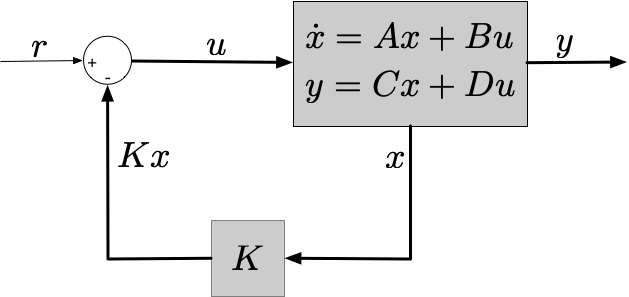


It turns out it is difficult to have an intuition about where to place the poles if you have a system with more than two state variables. However, it is easier and more intuitive to think about how you want your system to behave in terms of its performance and cost. LQR is a different view that takes into account the objective of the control system in the time-domain by explicitly minimizing a quadratic cost function in terms of state and input variables.

We are using the infinite-horizon, continuous-time formulation of the LQR. The name LQR comes from the following facts:  we are controlling a *linear* system, we use a cost function which is *quadratic* in control and error, and the *regulator* problem is concerned with sending $x(t)\rightarrow 0$. "Infinite-horizon" means we are considering the total cost as $t \rightarrow \infty$.

The cost $\widehat{J}$ is often defined as a sum of the deviations of key measurements (e.g. input voltage, $\delta[k]$)


$$\widehat{J} = \int_{0}^{\infty} {(x^TQx + u^TRu)dt}$$


We define $x^TQx$ to be the instantaneous cost of error and $u^TRu$ to be the instantaneous cost of control. $Q$ and $R$ are weighting factors that incorporate our preference in terms of performance ($x$) and cost ($u$). Because $x$ and $u$ are normally vectors, $Q$ and $R$ are *positive-definite* matrices that create a quadratic/convex cost function to optimize on. The integral is just summing the cost over all time steps.

The LQR algorithm reduces the amount of work done by the control systems engineer to optimize the controller. However, the engineer still needs to specify the cost function parameters, and compare the results with the specified design goals. Often this means that controller construction will be an iterative process in which the engineer judges the "optimal" controllers produced through simulation and then adjusts the parameters to produce a controller more consistent with design goals, which is what you will do in this lab.

The objective of LQR is to find a feedback matrix $K$ such that $u=-Kx$ minimizes the cost function. You do not have to do the math yourself as there are python packages that will do this for you. You can call something like `control.lqr(A, B, Q, R)` and it will return the optimal K that you can use to build your controller.

### Part 1

In [8]:
# define model parameters
Re = 5.5
Le = 50e-6
Kemf = 900e-6
KT = 900e-6
b = 300e-9
J = 15e-9


In [9]:
# Construct the control model matrices in terms of model parameters. 
# Do not use absoulute values.
# YOUR CODE HERE
Kc = Kemf
A = np.array([[-b/J, Kc/J],
             [-Kc/Le, -Re/Le]])
B = np.array([[0],
              [1/Le]])
C = np.array([[1, 0]])
D = 0

In [10]:
# Let's start with identity matrices for Q and R
Q = np.array([[1, 0],
              [0, 1]])
R = 1

In [11]:
# Compute the optimal K
K, S, E = control.lqr(A, B, Q, R)
print(K)

[[0.99706985 0.60183735]]


Great! You have the optimal K that minimizes your cost function (for a given $Q$ and $R$). Now you can start simulating the system and observe its behavior using LTSpice.

-----

**3.1.1. Find the optimal input $u = -Kx$ using the optimal K you found above. Draw your schematics in `cl_model.asc` and set your input accordingly in LTSPICE using the `.PARAM` directives at the bottom and simulate this control behaviour. Recall, the `.ic` directive is used to set the initial conditions of the state variables to values that are not equal to their final ones. For incorporating feedback we will use a behavioural voltage source. This is already set up for you in  `cl_model.asc`. Feel free to modify it to make it compatible with your own variable names.**

**Report the transient performance of your controller. Comment on the behaviour that you see.**

Hint: You can make your transient simulation time smaller, so that the transition is observable with naked eye.

Hint: You can use `.PARAM a = 2` to parameterically define a variable `a` in the circuit.

### 3.1.1. Answer:


We have $\vec{x} = \begin{bmatrix} \omega_r \\ i \end{bmatrix}$
and $K = \begin{bmatrix} k_1 & k_2 \end{bmatrix} = \begin{bmatrix} 0.99706985 & 0.60183735\end{bmatrix}$. So $u = -K\vec{x} = -\begin{bmatrix} k_1 & k_2 \end{bmatrix}\begin{bmatrix}\omega_r \\ i\end{bmatrix} = -k_1\omega_r - k_2i$

With feedback, a steady state is reached once everything goes to 0.
<img src="work/3.1.1_plots_white.jpg" alt="3.1.1_plots" width="1200"/> 
<img src="work/3.1.1_circuit.jpg" alt="3.1.1_circuit" width="1200"/> 

--------
**3.1.2. As we discussed earlier, the regulator problem is concerned with sending state variables to zero. How can you drive $\omega_r$ towards a nonzero desired $\omega^*$? Find the input $u = -Kx$ that sends $\omega_r(t)$ to $100 \ \frac{rad}{seconds}$. Show your work by including the modified schematic capture (with highlighted changes) and waveforms illustrating you successfully moved $\omega_r(t)$ from  $500\ \frac{rad}{seconds}$ to   $100 \ \frac{rad}{seconds}$**.

### 3.1.2. Answer:


<img src="work/3.1.2_plots.jpg" alt="3.1.2_plots" width="1200"/> 
<img src="work/3.1.2_circuit.jpg" alt="3.1.2_circuit" width="1200"/> 

-----

### Part 2

Now you can see the effect of different $Q$ and $R$ choices on the control behavior. 

**Use the following Q and R matrices. Plot case 0 with each case so you can compare the performance of each case to case 0 (i.e., you will have 4 sets of plots, one for each non-0 case, and case 0 will be shown on all the plots). In your report, intutively, explain the differences between case 0 and others. Make sure to show input ($V_{in}$) as well, since your explanation should depend on that.**


- Case 0: 
$$Q = I_{2\times 2}, R = 1$$
- Case 1: 
$$Q = I_{2\times 2}, R = 10$$
- Case 2: 
$$Q = \begin{bmatrix}1 & 0 \\ 0 & 10 \end{bmatrix}, R = 1$$
- Case 3: 
$$Q = \begin{bmatrix}10 & 0 \\ 0 & 1 \end{bmatrix}, R = 1$$
- Case 4: 
$$Q = 10I_{2\times 2}, R = 1$$

Hint: To plot different experiments on the same graph, you can make a copy of your circuits in the same file, and assign the appropriate values for each system before running the simulation. 

You can also do this by extracting the ascii data from the waveform viewer. To do this, click on the hammer on the plot and click on "Data Export Tool". Select the traces you want to save and choose an appropriate filename (look at the code below) before saving. Then you can use the method `read_ascii(fname)` to convert the ascii file to a dictionary from variable names to their numpy arrays, and then you can use matplotlib to plot on the same graph.

In [12]:
Q0 = np.eye(2)
R0 = 1
Q1 = np.eye(2)
R1 = 10
Q2 = np.eye(2)
Q2[1,1] = 10
Q3 = np.eye(2)
Q3[0,0] = 10
Q4 = 10*np.eye(2)

In [13]:
K0, S0, E0 = control.lqr(A, B, Q0, R0)

K1, S1, E1 = control.lqr(A, B, Q1, R1)
K2, S2, E2 = control.lqr(A, B, Q2, R0)
K3, S3, E3 = control.lqr(A, B, Q3, R0)
K4, S4, E4 = control.lqr(A, B, Q4, R0)
print("K0 = ", K0)
print("K1 = ", K1)
print("K2 = ", K2)
print("K3 = ", K3)
print("K4 = ", K4)

K0 =  [[0.99706985 0.60183735]]
K1 =  [[0.31344719 0.17720734]]
K2 =  [[0.99683784 1.29934019]]
K3 =  [[3.15901703 1.58548532]]
K4 =  [[3.15881424 2.19434113]]


### 3.2. Answer:


Successfully read the input files.


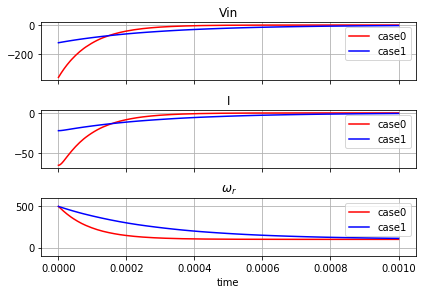

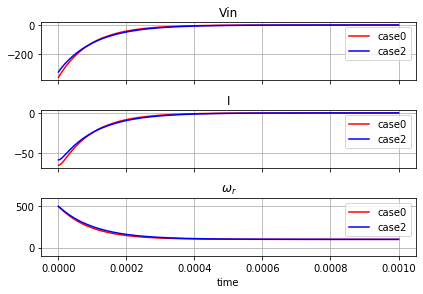

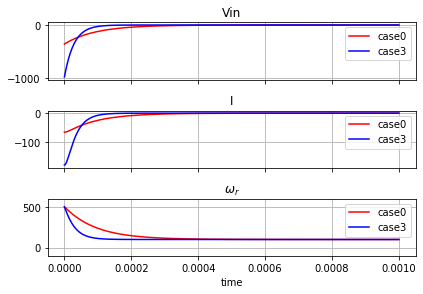

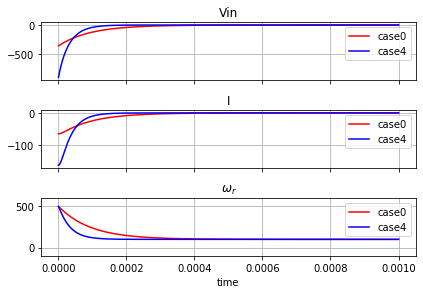

In [14]:
def read_ascii(fname):
    with open(fname, 'r') as f:
        keys = []
        values_list = []
        for i, line in enumerate(f):
            row = line.strip().split()
            if i == 0:
                keys = row
            else:
                values_list.append([float(x) for x in row])
                
        values_arr = np.array(values_list)
        return dict(zip(keys, values_arr.T))
                

case0 = read_ascii('cases/case0.txt')
case1 = read_ascii('cases/case1.txt')
case2 = read_ascii('cases/case2.txt')
case3 = read_ascii('cases/case3.txt')
case4 = read_ascii('cases/case4.txt')

print('Successfully read the input files.')

def plot_cases(cases):
    _, axes = plt.subplots(3,1, sharex=True)
    for i, (case, color, label) in enumerate(cases):
        axes[0].plot(case['time'], case['V(vin)'], color, label=label)
        axes[0].set_title('Vin')
        axes[1].plot(case['time'], case['I(L1)'], color, label=label)
        axes[1].set_title('I')
        axes[2].plot(case['time'], case['I(L2)'], color, label=label)
        axes[2].set_title(r'$\omega_r$')
        axes[2].set_ylim(bottom=-100, top=600)

    plt.tight_layout()
    for ax in axes:
        ax.legend(loc='upper right')
        ax.grid()
    plt.xlabel('time')

# choose your own comparisons like below
cases = [
    (case0, 'r', 'case0'),
    (case1, 'b', 'case1'),
]

plot_cases(cases)

cases = [
    (case0, 'r', 'case0'),
    (case2, 'b', 'case2'),
]

plot_cases(cases)

cases = [
    (case0, 'r', 'case0'),
    (case3, 'b', 'case3'),
]

plot_cases(cases)

cases = [
    (case0, 'r', 'case0'),
    (case4, 'b', 'case4'),
]

plot_cases(cases)

### 3.2. Explanation:
We want minimum cost and minimum error, while still having $\omega_r$ converge to 100 quickly.

Case 0 is the benchmark case, where cost of error and cost of control are weighted the same. $\omega_r$ converges to 100 in 0.2 ms. But $|V_{in}|$ has to go up to about 250 Volts.

Case 1 weights the cost of control more heavily, and so we're trying to minimize the energy spent on control. So $\omega_r$ converges to 100 more slowly than in case 0, but $|V_{in}|$ stays lower than in case 0.

Case 2 weights the cost of error on $i$ highly. But because the cost of control is low as in case 0, case 2 gives a similar convergence to 100.

Case 3 weights the cost of error on $\omega_r$ highly. So $\omega_r$ converges even faster than in case 0. But the low cost of controllability makes $|V_{in}|$ very large.

Case 4 weights the cost of error on both $\omega_r$ and $i$ heavily. So they both try to converge rapidly to their steady state values, so $|V_{in}|$ is very high.

-----

### Part 3

In this part we want you to pick the right $Q$ and $R$ matrices so that the optimal behavior satisfies some other properties. Let's assume we have a limitation on our driver such that it cannot provide more than 10 $V$. Design Q and R such that the controller achieves the fastest settling behavior subject to this constraint. 

Let's quantify the settling behavior. We will measure settling time by measuring the last time that the angular velocity hits its desired value ± 10%; i.e., time until output stays within 10% of the final value. We want to minimize this time by choosing the right trade-off weights ($Q$ and $R$) that give use the best time.

-----
** 3.3. Play with Q and R to find the best settling time such that the input constraint is satisfied. Measure the settling time. Try non-diagonal options and see if you get anything better than the diagonal case. Your figures should be clear and show the fact that you designed the correct controller.**

### 3.3. Answer:

In [15]:
# Your choice for Q and R.
# choice 1
# Q = np.eye(2)
# Q[1,1] = 100
# R = 1
# Compute the optimal K

# choice 2
Q = np.eye(2)
#Q[1,1] = 1
R = 1500

K, S, E = control.lqr(A, B, Q, R)
print(K)

[[0.02322659 0.01271496]]


### 3.3. Explanation:
We chose a $Q$ and $R$ so that there's a high cost on control, so that $|V_{in}|$ does not exceed 10 Volts. We do this by setting $Q = I_2$ and $R = 1500$. We get an error of 10.5%.
<img src="work/3.3_plots.jpg" alt="3_plots" width="1200"/> 
<img src="work/3.3_circuit.jpg" alt="3_circuit" width="1200"/> 

-----

### Part 4

Finaly, it is time to see how our controller deviates from its normal behavior when we have errors in model parameters.

**3.4. In your LTSpice simulation, use the mismatched values that were given earlier to simulate your controller. Compare the results with the open-loop model-mismatch case.**

### 3.4. Answer:
Using our controller from part 3.3, closed loop control also stabilizes with the model mismatch. Compared to open loop control, we have a 19% error instead of a 45% error.
<img src="work/3.4_plots.jpg" alt="3.4_plots" width="1200"/> 
<img src="work/3.4_circuit.jpg" alt="3.4_circuit" width="1200"/> 

-----

## Congratulations! You finished the lab portion of EE 16B! 

#### Don't forget:

* Turn in the `.pdf` and `.ipynb` versions of this notebook on gradescope.
* Fill out the partner participation form when it is released (after this is due).
* Check out the TI contest submissions on Piazza!
* If you enjoyed this course and would like to become a part of course staff, keep an eye out on Piazza for the application!

Thank you so much for bearing with us this semester, and have a good summer!

